## Reference
https://openaccess.thecvf.com/content/WACV2021/papers/Miller_Class_Anchor_Clustering_A_Loss_for_Distance-Based_Open_Set_Recognition_WACV_2021_paper.pdf

# 1. Data & Preprocessing

In [1]:
import os

import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import Dataset

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import argparse

from sklearn.metrics import confusion_matrix

from sklearn.cluster import DBSCAN

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Random seed (for reproducibility)
SEED = 8
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [2]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## Datasets, dataloaders and transformations

In [3]:
BATCH_SIZE = 128

In [4]:
class data_set(Dataset):
  """for Combined dataset."""
  def __init__(self, dataset, targets):
    self.dataset = dataset
    self.targets = targets
      
  def __getitem__(self, idx):
    image = self.dataset[idx][0]
    target = self.targets[idx]
    return (image, target)

  def __len__(self):
    return len(self.dataset)

MNIST - for training

In [5]:
mnist_transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(
                                  (0.1307,),
                                  (0.3081,)), # mnist mean & std
                              transforms.Resize(28)])

mnist_train_set = torchvision.datasets.MNIST(root='./data',
                                                 train=True,
                                                 download=True,
                                                 transform=mnist_transform)

mnist_test_set = torchvision.datasets.MNIST(root='./data',
                                            train=False,
                                            download=True,
                                            transform=mnist_transform)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train_set,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 num_workers=2)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test_set,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



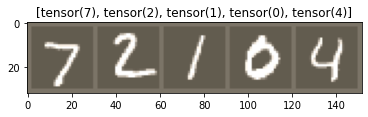

In [6]:
# Printing 5 MNIST data examples
inputs, classes = next(iter(mnist_test_loader))
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[x for x in classes[:5]])

CIFAR10 as OOD dataset - for evaluation

In [60]:
CIFAR10_SUBSET_SIZE = 1000

cifar10_transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(
                                  (0.4914, 0.4822, 0.4465),
                                  (0.247, 0.243, 0.261)), # cifar10 mean & std
                              transforms.Resize(28),
                              transforms.Grayscale(num_output_channels=1)])

cifar10_test_set = torchvision.datasets.CIFAR10(root='./data',
                                              train=False,
                                              download=True,
                                              transform=cifar10_transform)

cifar10_test_subset_data = torch.utils.data.Subset(cifar10_test_set,
                                                   np.random.choice(range(len(cifar10_test_set)),
                                                                    size=CIFAR10_SUBSET_SIZE))
sub_cifar10_targets = [10 for i in range(CIFAR10_SUBSET_SIZE)]
cifar10_test_subset = data_set(cifar10_test_subset_data, sub_cifar10_targets)

cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_subset,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                num_workers=2)

Files already downloaded and verified


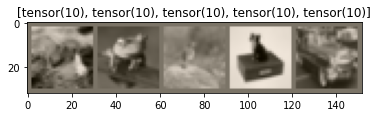

In [8]:
# Printing 5 CIFAR10 data examples
inputs, classes = next(iter(cifar10_test_loader))
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[x for x in classes[:5]])

In [64]:
combined_test_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset([mnist_test_set, cifar10_test_subset]),
        batch_size=BATCH_SIZE, shuffle=True)

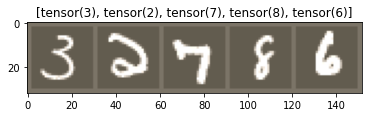

In [10]:
# Printing 5 COMBINED data examples
inputs, classes = next(iter(combined_test_loader))
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[x for x in classes[:5]])


# 2. Models

In [11]:
def out_size(W, F, S, P):
  return ((W-F+2*P) // S) + 1

Baseline model class

In [12]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
    self.conv3 = nn.Conv2d(32,64, kernel_size=5)
    self.fc1 = nn.Linear(3*3*64, 256)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.dropout(x, p=0.5, training=self.training)

    x = F.relu(F.avg_pool2d(self.conv2(x), 2))
    x = F.dropout(x, p=0.5, training=self.training)

    x = F.relu(F.avg_pool2d(self.conv3(x),2))
    x = F.dropout(x, p=0.5, training=self.training)

    x = x.view(-1, 3*3*64)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)

    x = self.fc2(x)
    return x

OSR model class

In [13]:
class OSR(nn.Module):
  def __init__(self, cnn, init_weights = False, dropout = 0.3, **kwargs):
    super(OSR, self).__init__()

    self.num_classes = 10
    self.cnn = cnn
    self.classify = nn.Linear(10, self.num_classes)
    self.anchors = nn.Parameter(torch.zeros(self.num_classes, self.num_classes).double(), requires_grad = False)

  def forward(self, x):
    batch_size = len(x)
    x = self.cnn(x)
    outLinear = x.view(batch_size, -1)
    outLinear = self.classify(x)
    outDistance = self.distance_classifier(outLinear)

    return outDistance

  def distance_classifier(self, outLinear):
    ''' Calculates euclidean distance from outLinear to each class anchor
      Returns n x m array of distance from input of batch_size n to anchors of size m
    '''
    n = outLinear.size(0)
    m = self.num_classes
    d = self.num_classes

    outLinear = outLinear.unsqueeze(1).expand(n, m, d).double()
    anchors = self.anchors.unsqueeze(0).expand(n, m, d)
    dists = torch.norm(outLinear-anchors, 2, 2)

    return dists

  def set_anchors(self, means):
    self.anchors = nn.Parameter(means.double(), requires_grad = False)
    self.cuda()

# 3. Training

In [14]:
def train_cnn(model, train_loader):
  optimizer = torch.optim.Adam(model.parameters())#,lr=0.001, betas=(0.9,0.999))
  criterion = nn.CrossEntropyLoss()
  EPOCHS = 5 # return to 5 at the end
  model.train()
  
  for epoch in range(EPOCHS):
    print('--------------------- Epoch : {} -------------------'.format(epoch))
    correct = 0
    loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      # Total correct predictions
      predicted = torch.max(outputs.data, 1)[1] 
      correct += (predicted == targets).sum()
      #print(correct)
      if batch_idx % 100 == 0:
        print('[{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
              batch_idx*len(inputs),
              len(train_loader.dataset),
              100.*batch_idx / len(train_loader),
              loss.data,
              float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

In [15]:
def CACLoss(distances, gt):
	'''Returns CAC loss, as well as the Anchor and Tuplet loss components separately for visualisation.'''
	true = torch.gather(distances, 1, gt.view(-1, 1)).view(-1)
	non_gt = torch.Tensor([[i for i in range(10) if gt[x] != i] for x in range(len(distances))]).long().to(device)
	others = torch.gather(distances, 1, non_gt)
	
	anchor = torch.mean(true)

	tuplet = torch.exp(-others+true.unsqueeze(1))
	tuplet = torch.mean(torch.log(1+torch.sum(tuplet, dim = 1)))

	total = 0.1*anchor + tuplet

	return total, anchor, tuplet

In [28]:
def train_osr(model, train_loader):
  optimizer = torch.optim.Adam(model.parameters())#,lr=0.001, betas=(0.9,0.999))
  criterion = nn.CrossEntropyLoss()
  EPOCHS = 5 # return to 5 at the end
  model.train()

  for epoch in range(EPOCHS):
    print('--------------------- Epoch : {} -------------------'.format(epoch))
    loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
      inputs, targets = inputs.to(device), targets.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      cacLoss, anchorLoss, tupletLoss = CACLoss(outputs, targets)

      cacLoss.backward()

      optimizer.step()

      loss = cacLoss.item()
      _, predicted = outputs.min(1)
      correct += predicted.eq(targets).sum().item()
      #print(correct)
      if batch_idx % 100 == 0:
        print('[{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
              batch_idx*len(inputs),
              len(train_loader.dataset),
              100.*batch_idx / len(train_loader),
              loss,
              float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))


Training procedure for baseline model

In [17]:
cnn = CNN()
if torch.cuda.is_available():
    cnn.cuda()
train_cnn(cnn, mnist_train_loader)

--------------------- Epoch : 0 -------------------
[0/60000 (0%)]	Loss: 2.297710	 Accuracy:7.812%
[12800/60000 (21%)]	Loss: 0.499258	 Accuracy:71.697%
[25600/60000 (43%)]	Loss: 0.185691	 Accuracy:81.367%
[38400/60000 (64%)]	Loss: 0.164285	 Accuracy:85.613%
[51200/60000 (85%)]	Loss: 0.176800	 Accuracy:87.899%
--------------------- Epoch : 1 -------------------
[0/60000 (0%)]	Loss: 0.123242	 Accuracy:95.312%
[12800/60000 (21%)]	Loss: 0.123671	 Accuracy:95.753%
[25600/60000 (43%)]	Loss: 0.214432	 Accuracy:95.864%
[38400/60000 (64%)]	Loss: 0.140310	 Accuracy:95.941%
[51200/60000 (85%)]	Loss: 0.072384	 Accuracy:96.131%
--------------------- Epoch : 2 -------------------
[0/60000 (0%)]	Loss: 0.299632	 Accuracy:92.969%
[12800/60000 (21%)]	Loss: 0.077048	 Accuracy:97.014%
[25600/60000 (43%)]	Loss: 0.099869	 Accuracy:96.875%
[38400/60000 (64%)]	Loss: 0.063720	 Accuracy:96.940%
[51200/60000 (85%)]	Loss: 0.081687	 Accuracy:96.965%
--------------------- Epoch : 3 -------------------
[0/60000 (0%)

Training procedure for OSR model

In [18]:
def gather_outputs(model, data_loader):
    ''' Tests data and returns outputs and their ground truth labels.
        data_idx        0 returns logits, 1 returns distances to anchors
        use_softmax     True to apply softmax
        unknown         True if an unknown dataset
        only_correct    True to filter for correct classifications as per logits
    '''
    X = []
    y = []

    softmax = torch.nn.Softmax(dim = 1)

    for i, data in enumerate(data_loader):
        images, labels = data
        images = images.cuda()
        targets = labels
        
        outputs = model(images)
        distances = outputs

        softmin = softmax(-distances)
        invScores = 1-softmin
        scores = distances*invScores

        X += scores.cpu().detach().tolist()
        y += targets.cpu().tolist()

    X = np.asarray(X)
    y = np.asarray(y)

    return X, y

In [19]:
def find_anchor_means(model):
  ''' Tests data and fits a multivariate gaussian to each class' logits. 
      If dataloaderFlip is not None, also test with flipped images. 
      Returns means and covariances for each class. '''
  logits, labels = gather_outputs(model, mnist_train_loader)

  num_classes = 10
  means = [None for i in range(num_classes)]

  for cl in range(num_classes):
      x = logits[labels == cl]
      x = np.squeeze(x)
      means[cl] = np.mean(x, axis = 0)

  return means

In [32]:
osr = OSR(cnn)
if torch.cuda.is_available():
  osr.cuda()

anchors = torch.diag(torch.Tensor([10 for i in range(10)]))	
osr.set_anchors(anchors)

train_osr(osr, mnist_train_loader)

--------------------- Epoch : 0 -------------------
[0/60000 (0%)]	Loss: 7.302916	 Accuracy:8.594%
[12800/60000 (21%)]	Loss: 1.426503	 Accuracy:40.408%
[25600/60000 (43%)]	Loss: 0.815156	 Accuracy:65.229%
[38400/60000 (64%)]	Loss: 0.704421	 Accuracy:75.073%
[51200/60000 (85%)]	Loss: 0.583037	 Accuracy:80.295%
--------------------- Epoch : 1 -------------------
[0/60000 (0%)]	Loss: 0.552177	 Accuracy:96.875%
[12800/60000 (21%)]	Loss: 0.513462	 Accuracy:97.355%
[25600/60000 (43%)]	Loss: 0.516014	 Accuracy:97.264%
[38400/60000 (64%)]	Loss: 0.578195	 Accuracy:97.373%
[51200/60000 (85%)]	Loss: 0.487476	 Accuracy:97.407%
--------------------- Epoch : 2 -------------------
[0/60000 (0%)]	Loss: 0.453794	 Accuracy:96.875%
[12800/60000 (21%)]	Loss: 0.410983	 Accuracy:97.935%
[25600/60000 (43%)]	Loss: 0.356031	 Accuracy:97.851%
[38400/60000 (64%)]	Loss: 0.498158	 Accuracy:97.846%
[51200/60000 (85%)]	Loss: 0.450774	 Accuracy:97.960%
--------------------- Epoch : 3 -------------------
[0/60000 (0%)

# 4. Evaluation

In [20]:
def evaluate_cnn(model, labels, test_loader):
  y_true = []
  y_pred = []
  correct = 0
  with torch.no_grad():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      predicted = torch.max(outputs, 1)[1]
      correct += (predicted == targets).sum()

      y_true += list(targets.detach().cpu())
      y_pred += list(predicted.detach().cpu())

    print("Test accuracy:{:.3f}% ".format(
        float(correct*100) / (len(test_loader)*BATCH_SIZE)))
    a = confusion_matrix(y_true, y_pred, labels=labels)
  return a

In [61]:
dictionary = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:1}

def get_prediction(outputs, threshold = 0.5):
  softmin = torch.nn.Softmax(dim = 1)
  invScores = 1-softmin(-outputs)
  scores = torch.Tensor(outputs*invScores).detach().cpu()
  pred_value, prediction = torch.min(scores, axis = 1)
  prediction[pred_value > threshold] = 10
  
  return prediction

def evaluate_osr(model,  labels, test_loader, binary=False):
  y_true = []
  y_pred = []
  correct = 0
  with torch.no_grad():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      predicted = get_prediction(outputs)

      correct += (predicted == targets.detach().cpu()).sum()

      y_true += list(targets.detach().cpu())
      y_pred += list(predicted.detach().cpu())

    if binary:
      y_true = [dictionary[int(y)] for y in y_true]
      y_pred = [dictionary[int(y)] for y in y_pred]

    print("Test accuracy:{:.3f}% ".format(
        float(correct*100) / (len(test_loader)*BATCH_SIZE)))
    a = confusion_matrix(y_true, y_pred, labels=labels)
  return a

In [71]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(combined_test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            predicted = get_prediction(outputs)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {predicted[j]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Baseline results

In [23]:
baseline_c_matrix = evaluate_cnn(cnn, range(10), mnist_test_loader)
print(baseline_c_matrix)

Test accuracy:96.667% 
[[ 964    0    1    1    4    0    5    2    1    2]
 [   0 1127    4    1    0    1    1    1    0    0]
 [   3    0 1010    3    1    0    1   14    0    0]
 [   0    1    0  998    0    2    0    6    2    1]
 [   0    1    0    0  955    0    4    3    4   15]
 [   3    0    0   13    0  863    6    1    1    5]
 [   3    3    1    0    7    1  939    0    3    1]
 [   0   12   10    0    2    1    0  994    1    8]
 [   4    1    1    4    2    2    2    5  944    9]
 [   2    5    0    2    5    4    0    6    4  981]]


OSR rational

:TODO

OOD results

In [66]:
ood_c_matrix = evaluate_osr(osr, range(2), combined_test_loader, True)
print(ood_c_matrix)

Test accuracy:92.723% 
[[9552  448]
 [ 302  698]]


OSR results

In [65]:
osr_c_matrix = evaluate_osr(osr, range(11), combined_test_loader)
print(osr_c_matrix)

Test accuracy:92.769% 
[[ 948    0    0    0    0    0    0    1    0    0   31]
 [   0 1112    0    0    0    1    0    1    0    0   21]
 [   0    0  989    0    0    0    0    0    0    0   43]
 [   0    0    0  959    0    2    0    2    1    0   46]
 [   0    0    1    0  922    0    0    0    0    4   55]
 [   1    0    0    1    0  848    1    0    0    0   41]
 [   4    2    0    0    0    0  905    0    0    0   47]
 [   0    3    2    0    0    0    0  972    0    2   49]
 [   1    0    1    0    1    0    1    0  902    2   66]
 [   0    1    0    0    4    0    0    0    0  937   67]
 [  21   83   51   10   25   52    4   32    4    0  718]]


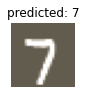

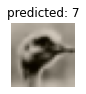

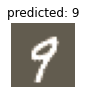

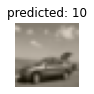

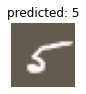

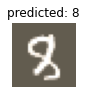

In [74]:
visualize_model(osr, 6)